#Introducci√≥n

Este proyecto se ha realizado con el objetivo de familiarizarse con tareas de redes sociales y los instrumentos usados para ello como parte del m√≥dulo de Text mining y redes sociales impartido por Luis Gasc√≥ en el M√°ster Data Science, Big Data & Business Analytics de la Universidad Complutense de Madrid.

Se a formateado la notebook con respecto a la generada para la tarea con el objetivo de simplificar su visualizaci√≥n.

El proyecto se compone del an√°lisis topol√≥gico, de conectividad de red y de relevancia de nodos, y su representaci√≥n gr√°fica por medio de NetworkX, de una [base de datos](https://github.com/luisgasco/ntic_master_datos/files/10912179/datos_ejercicio_twitter.zip) generada por [Luis Gasc√≥](https://github.com/luisgasco) y basada en la reducci√≥n de la shared-task [SocialDisNER](https://temu.bsc.es/socialdisner/) (celebrada en el a√±o 2022), eligiendo un conjunto de 100 cuentas seed, de las que se descargaron sus seguidores y los seguidores de sus seguidores y filtrando algunas de las cuentas.

# 0. Imports

In [ ]:
# Cargamos e instalamos librer√≠a que se utilizar√°
!pip install networkx[default]
!pip install matplotlib==3.1.3
!pip install scipy==1.10.1

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import string
import pandas as pd
import seaborn as sns
import numpy as np

# 1. Descarga y carga de datos

## Descargamos los datos

Descargamos los datos y los descomprimimos.

In [ ]:
!wget https://github.com/luisgasco/ntic_master_datos/files/10912179/datos_ejercicio_twitter.zip
!unzip datos_ejercicio_twitter.zip

## Cargamos los nodos y las aristas

In [ ]:
nodos = pd.read_csv("nodos_ejercicio.tsv",sep="\t")
aristas = pd.read_csv("aristas_ejercicio.tsv",sep="\t")

Eliminamos dos nodos de los datos cargados, ya que si no obtendremos un subgrafo dirigido con dos componentes, que no entra dentro del prop√≥sito del proyecto. Quitando dos nodos (que previamente he comprobado que son los que generan el segundo componente) conseguiremos un grafo con un √∫nico componente:

In [ ]:
nodos = nodos[~nodos.Target.isin([187715558, 201414730])].copy()
aristas = aristas[~aristas.Target.isin([187715558, 201414730])].copy()

Observamos las columnas que componen el dataset aristas, establecemos una copia de la columna Target como indice coincidente en ambos datasets (id_source).

## Fijamos √≠ndices comunes

Observamos las columnas que componen el dataset y establecemos una copia de la columna Source como indice coincidente en ambos datasets (id_source)

In [ ]:
aristas.head()
aristas["id_source"]=aristas.Source
aristas=aristas.set_index("id_source")
aristas.head(1)

Source              Target
id_source                                 
2838611488  2838611488  920282323446312960

Observamos las columnas que componen el dataset nodos y establecemos una copia de la columna Target como indice coincidente en ambos datasets (id_source).


In [ ]:
nodos.head()

nodos["id_source"]=nodos.Target
nodos=nodos.set_index("id_source")
nodos.head(1)

Target  \
id_source                                
920282323446312960  920282323446312960   

                                                          description  \
id_source                                                               
920282323446312960  Perfil oficial de la Asociaci√≥n Espa√±ola de La...   

                         grupo  
id_source                       
920282323446312960  asociacion

In [ ]:
nodos.groupby("grupo").size()

grupo
asociacion    332
fundacion      17
no_class      206
ong            35
dtype: int64

## Creamos el grafo

Componemos el grafo en base a la lista de aristas, a√±adimos los nodos de la lista nodos y comprobamos la existencia de direccionalidad

In [ ]:
G = nx.from_pandas_edgelist(aristas, "Source","Target", create_using=nx.DiGraph())
G.add_nodes_from(nodos)
G.is_directed()

True

# 2. An√°lisis topol√≥gico

## Mostramos el conteo de aristas y nodos del grafo

In [ ]:
print("Dentro de este grafo hay un total de {} nodos (que representan cuentas).\n".format(G.number_of_nodes()))
print("En el grafo hay un total de {} aristas diferentes (que representan relaciones entre cuentas).".format(G.number_of_edges()))

Dentro de este grafo hay un total de 625 nodos (que representan cuentas).

En el grafo hay un total de 10122 aristas diferentes (que representan relaciones entre cuentas).


## Representamos los 20 nodos con mayor n√∫mero de seguidores y los 20 con mayor n√∫mero de seguidos

Obtenemos diccionarios de nodos ordenados seg√∫n el n√∫mero de seguidores y seguidos para representar aquellos con mayor cantidad.

Filtramos ambos diccionarios para obtener los cinco primeros.

Creamos subplots para representar ambos en una misma l√≠nea y transformamos en datasets los diccionarios y la columna usuarios en cadenas de texto.

Establecemos el primer gr√°fico de barras, que representa top_seguidores, fijando sus valores en la parte superior de las columnas, su t√≠tulo, las condiciones en las etiquetas del eje X y su longitud representada en el eje Y. Repetimos el proceso adapt√°ndonos a las condiciones del segundo gr√°fico de barras, top_seguidos.

Por √∫ltimo, ajustamos el tama√±o del conjunto de gr√°ficos y visualizamos el resultado.

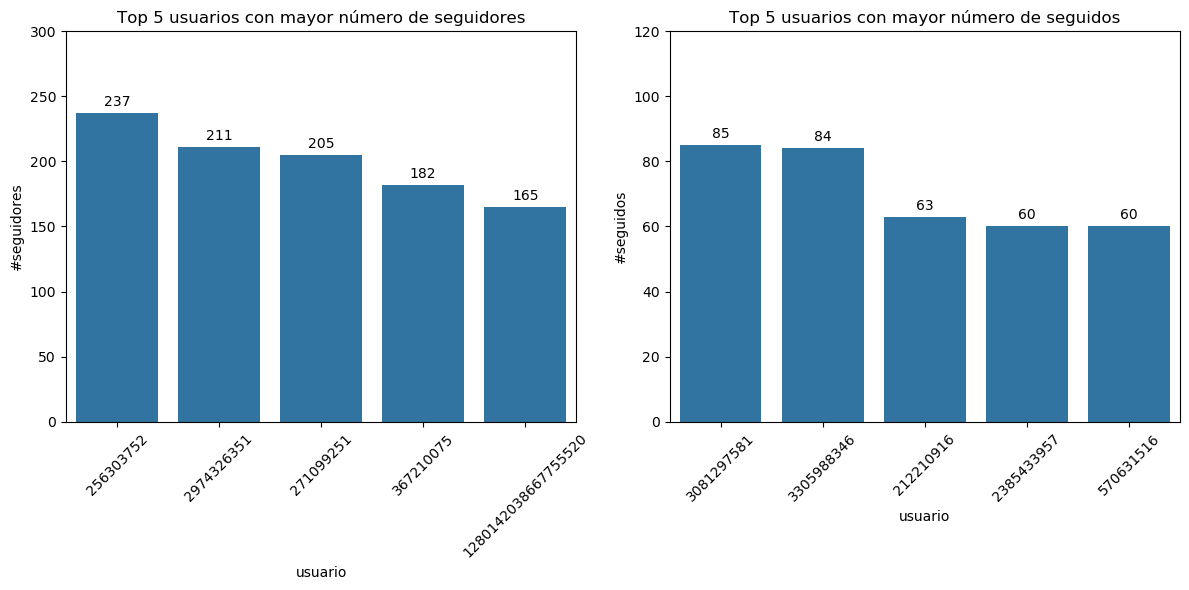

In [ ]:
dict_seguidores = sorted(G.in_degree(), key=lambda x: x[1],reverse=True)
dict_seguidos= sorted(G.out_degree(), key=lambda x: x[1],reverse=True)

top_seguidores = dict_seguidores[:5]
top_seguidos = dict_seguidos[:5]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

df1 = pd.DataFrame(top_seguidores, columns=["usuario", "#seguidores"])
df1.usuario = df1.usuario.astype(str)
df2 = pd.DataFrame(top_seguidos, columns=["usuario", "#seguidos"])
df2.usuario = df2.usuario.astype(str)

sns.barplot(data=df1, x="usuario", y="#seguidores", ax=axes[0])
axes[0].set_title("Top 5 usuarios con mayor n√∫mero de seguidores")
axes[0].tick_params(axis='x', rotation=45, labelsize=10)

for index, row in df1.iterrows():
    axes[0].annotate(f"{row['#seguidores']}", (index, row['#seguidores']),
                     xytext=(0, 3), textcoords='offset points',
                     ha='center', va='bottom')

axes[0].set_ylim(0, 300)

sns.barplot(data=df2, x="usuario", y="#seguidos", ax=axes[1])
axes[1].set_title("Top 5 usuarios con mayor n√∫mero de seguidos")
axes[1].tick_params(axis='x', rotation=45, labelsize=10)

for index, row in df2.iterrows():
    axes[1].annotate(f"{row['#seguidos']}", (index, row['#seguidos']),
                     xytext=(0, 3), textcoords='offset points',
                     ha='center', va='bottom')

axes[1].set_ylim(0, 120)

plt.tight_layout()

plt.show()

# 3. Conectividad de red

## Comprobamos la conectividad de red

Comprobamos que todos los elementos de la red pueden llegar al resto de v√©rtices. Utilizamos ".is_semiconnected(G)" en vez de ".is_connected(G)" dado que se trata de una red direccional. Obtendr√≠amos el mismo resultado aplicando is_connected(H) a H = G.to_directed()

In [ ]:
conexion = nx.is_semiconnected(G)
if conexion == False:
  print("No todos los elementos de la red pueden llegar al resto de v√©rtices.")
else:
      print("Si, todos los elementos de la red pueden llegar al resto de v√©rtices.")


No todos los elementos de la red pueden llegar al resto de v√©rtices.


## Representamos el histograma de longitudes de los caminos m√°s cortos

Calculamos los caminos, los extraemos en una lista y creamos un histograma con las longitudes de los caminos m√°s cortos

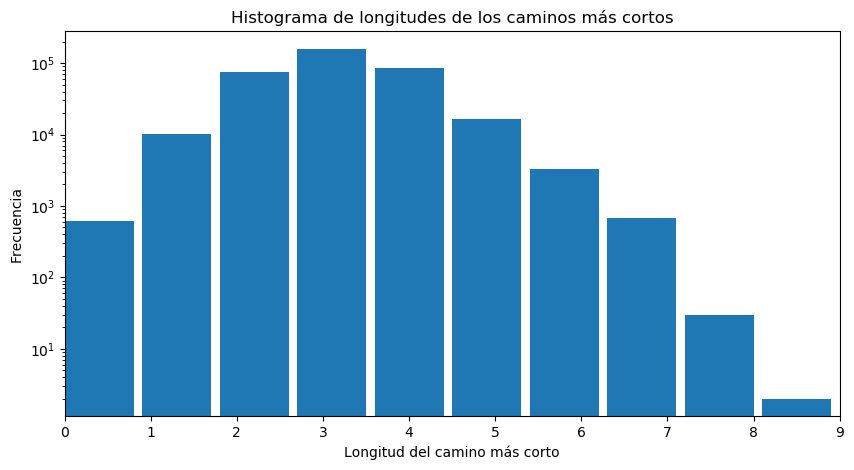

In [ ]:
all_caminos_cortos = dict(nx.all_pairs_shortest_path_length(G)) # Calculo de todos los caminos m√°s cortos: all_pairs_shortest_path_length(G)
caminos_cortos_lengths = [length for source in all_caminos_cortos for target, length in all_caminos_cortos[source].items()]
plt.figure(figsize=(10, 5))
plt.hist(caminos_cortos_lengths, bins=10, range=(0, max(caminos_cortos_lengths)), width=0.8)
plt.title("Histograma de longitudes de los caminos m√°s cortos")
plt.xlabel("Longitud del camino m√°s corto")
plt.ylabel("Frecuencia")
plt.xlim(0,9)
plt.yscale("log")
plt.show()

## Analizamos el coeficiente de clustering

Obtenemos el coeficiente de agrupamiento medio del grafo


In [ ]:
nx.average_clustering(G)

0.22355357916362337

Representamos la distribuci√≥n del coeficiente de agrupamiento

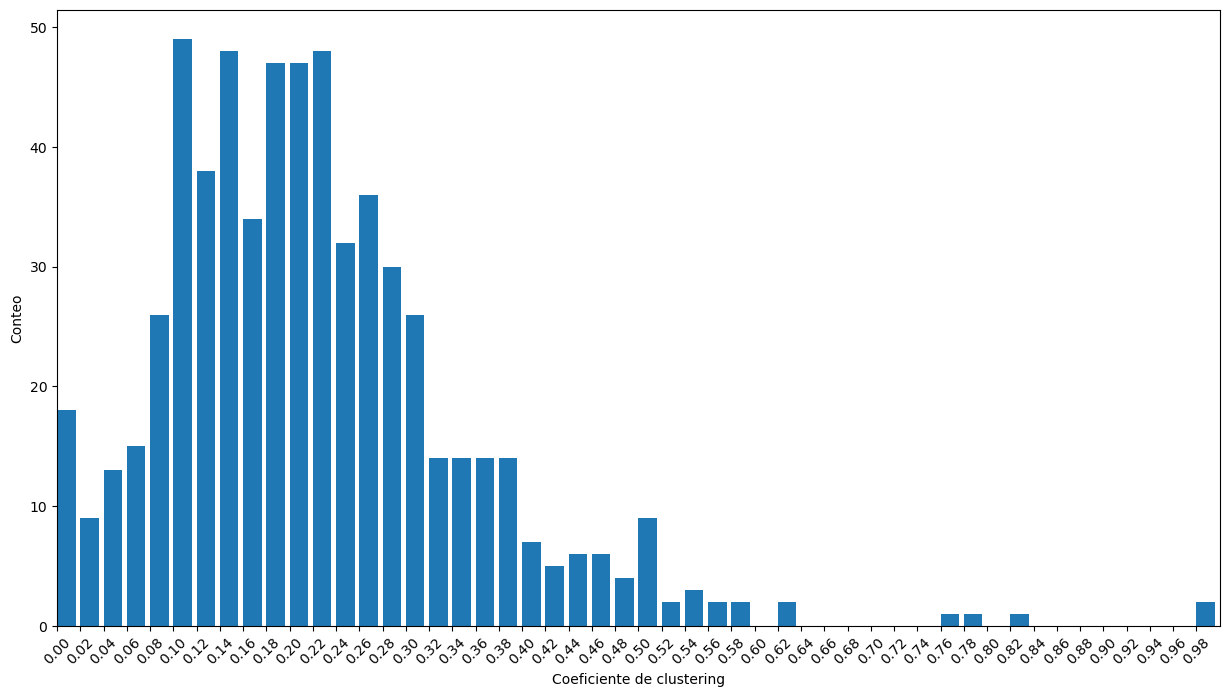

In [ ]:
plt.figure(figsize=(15, 8))
plt.hist(nx.clustering(G).values(), bins=50, width=(1/50)*0.8)
plt.xlabel("Coeficiente de clustering", fontdict={"size": 10})
plt.ylabel("Conteo")
plt.xticks(np.arange(0, 1, 1/50))
plt.xlim(0,1)
plt.tick_params(axis='x', rotation=45, labelsize=10)

# 4. Relevancia de nodos

### ¬øC√∫al es la distribuci√≥n de centralidad de cercan√≠a de la red? ¬øC√≥mo se interpreta? ¬øC√∫al es el elemento m√°s relevante seg√∫n esta m√©trica?


Text(0, 0.5, 'Counts')

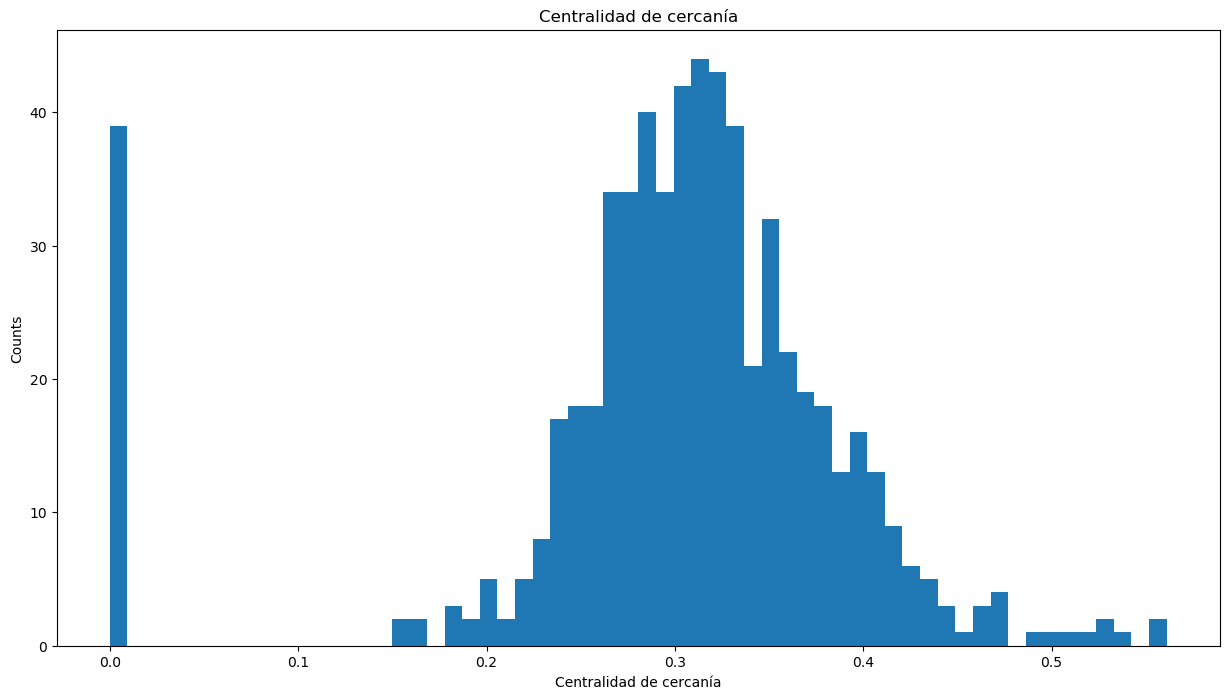

In [ ]:
plt.figure(figsize=(15, 8))
plt.hist(nx.closeness_centrality(G).values(), bins=60)
plt.title("Centralidad de cercan√≠a")
plt.xlabel("Centralidad de cercan√≠a")
plt.ylabel("Counts")

Al tratarse de una red direccional, no queda claro a primera vista el proceso que se sigue para llevar a cabo el c√°lculo de la medida. Si bien damos por hecho que esta est√° normalizada, dada la falta de presencia de elementos con valor 1.

La medida es una muestra de la influencia en la red, en tanto que refleja una distancia corta al resto de nodos. As√≠, el elemento m√°s relevante ser√≠a aquel que toma menores valores en su coeficiente de centralidad de cercan√≠a, en este caso entorno al 0,05 (dejando al margen los contenidos en 0). Esto implica un mayor n√∫mero de relaciones directas con el resto de la red, lo que lleva a una reducci√≥n de la distancia media con el conjunto. En otras palabras, este nodo es un nodo con muchas relaciones salientes, es decir, que "sigue" a muchas personas.

El valor del coeficiente 0 en una proporci√≥n considerable de los grafos se debe a la inexistencia de grados de salida, lo que se interpreta como la inexistencia de "seguidos" dentro de la muestra obtenida de la red social.

Al margen de aquellos con valor cero, que no significan una cercan√≠a exacerbada, cabe destacar esta medida como signo de la presencia de una tendencia centralizada, donde un achatamiento del pico implicar√≠a una mayor descentralizaci√≥n de la tendencia. Los valores mayores se√±alan aquellos nodos en la periferia del grafo.

### ¬øC√∫al es la distribuci√≥n de la m√©trica centralidad de intermediaci√≥n de la red? ¬øC√≥mo interpretas los resultados?




Text(0, 0.5, 'Counts')

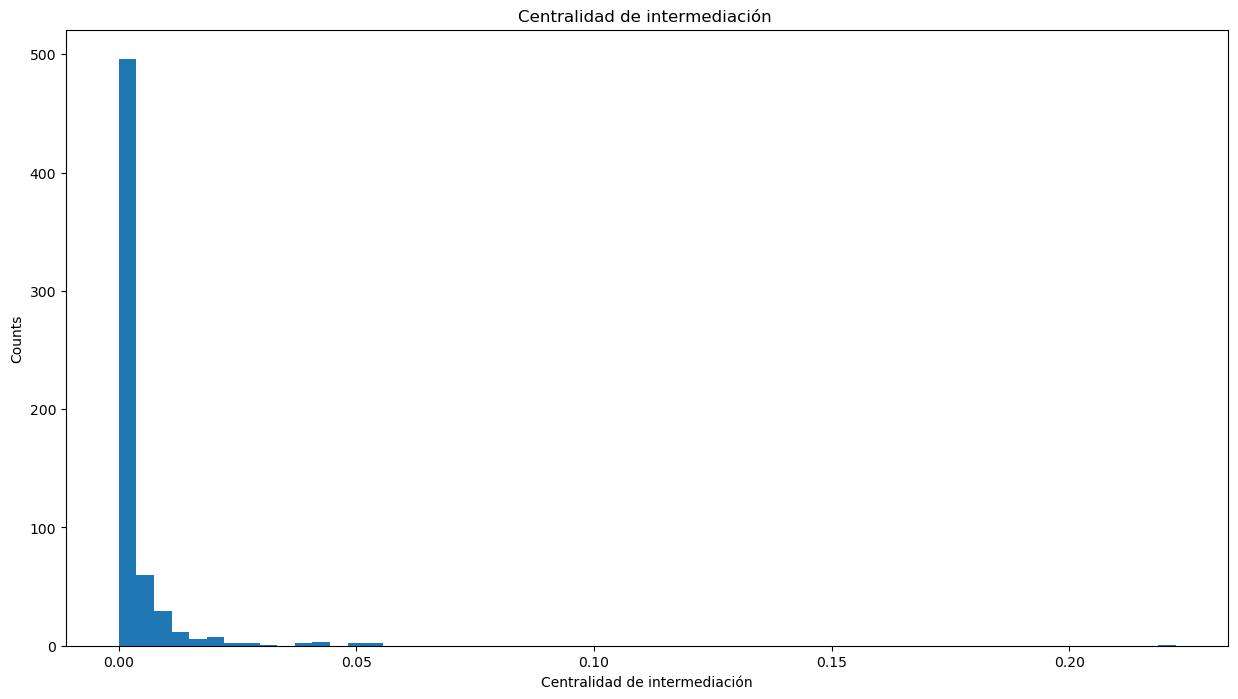

In [ ]:
plt.figure(figsize=(15, 8))
plt.hist(nx.betweenness_centrality(G,normalized = True, endpoints = False, k = 10).values(), bins=60)
plt.title("Centralidad de intermediaci√≥n ")
plt.xlabel("Centralidad de intermediaci√≥n")
plt.ylabel("Counts")

La medida nos permite identificar nodos presentes en el conjunto de caminos m√°s cortos con el resto de nodos presentes en los grafos. Entendemos que aquellos que toman valores altos son l√≠deres de opini√≥n capaces de aunar gran cantidad de subgrupos de la comunidad, sirviendo de puente entre usuarios de distintas preferencias, comunidades, gustos o rasgos.

### ¬øC√∫al es la distribuci√≥n de la m√©trica PageRank de la red? ¬øc√≥mo lo interpretas?

Text(0, 0.5, 'Counts')

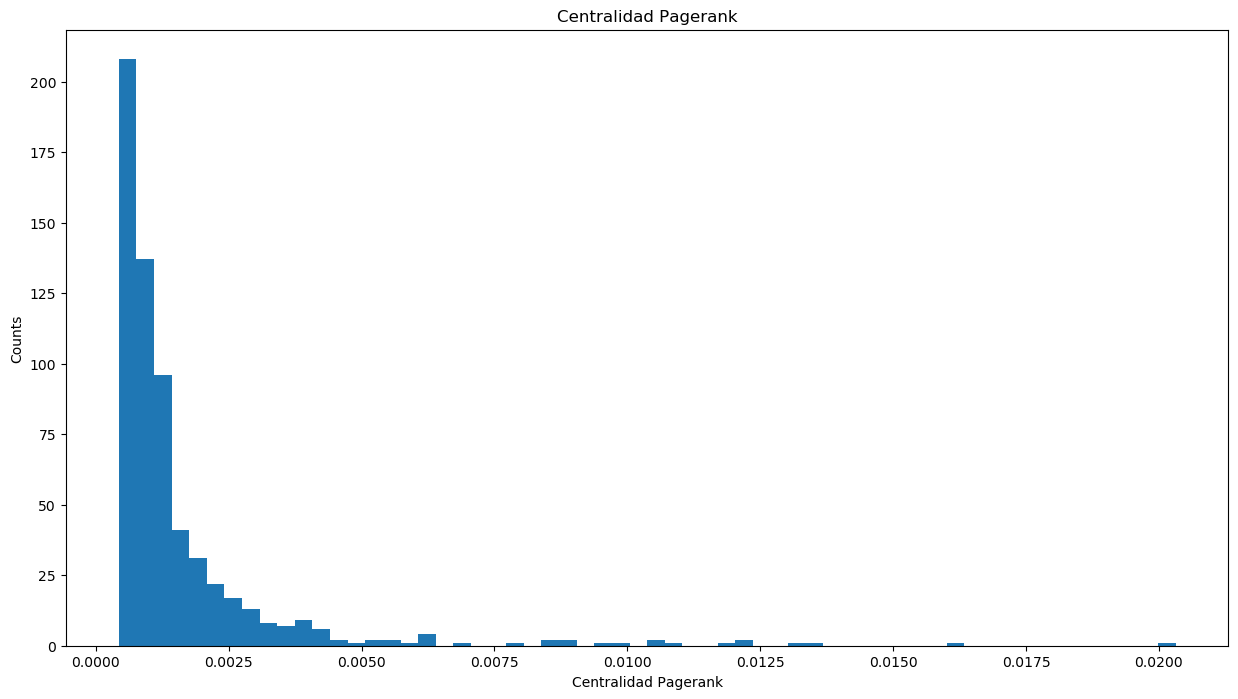

In [ ]:
plt.figure(figsize=(15, 8))
plt.hist(nx.pagerank(G, alpha=0.8).values(), bins=60)
plt.title("Centralidad Pagerank")
plt.xlabel("Centralidad Pagerank")
plt.ylabel("Counts")

La medida suaviza la tendencia previa al considerar la influencia de los nodos de entrada con un factor multiplicador del radio con respecto al total de aristas del nodo del que proviene ese grado de entrada. Aun no siendo el camino m√°s corto dentro de la muestra, algunos nodos s√≠ tienen relaciones de entrada con otros, lo que hace que el acumulado de cero se reduzca notablemente.

### Representamos en un dataframe los nodos el top-20 de nodos con mayor centralidad de cercan√≠a y pagerank. ¬øC√∫al es la clase asignada a estos nodos? ¬øExiste alg√∫n patr√≥n?

In [ ]:
closeness_top20 = sorted(nx.closeness_centrality(G).items(), key=lambda item: item[1], reverse=True)[:20]
dict_close =  {t[0]: t[1] for t in closeness_top20}
pagerank_top20 = sorted(nx.pagerank(G, alpha=0.8).items(), key=lambda item: item[1], reverse=True)[:20]
dict_page = {t[0]: t[1] for t in pagerank_top20}

In [ ]:
df = pd.DataFrame({'closeness': dict_close, 'pagerank': dict_page})
df = df.sort_values("closeness",ascending=False)
df = df.rename_axis('id_source')
merged_dataset = pd.merge(df, nodos, on = "id_source")
merged_dataset

closeness  pagerank               Target  \
id_source                                                       
256303752             0.561069  0.012241            256303752   
2974326351            0.554532  0.020313           2974326351   
271099251             0.537823  0.010646            271099251   
367210075             0.528628  0.013533            367210075   
1280142038667755520   0.525116  0.016225  1280142038667755520   
308131267             0.516828  0.012182            308131267   
198867180             0.505012  0.013306            198867180   
847726106937409536    0.501747  0.009446   847726106937409536   
1327897933036072963   0.492340  0.010967  1327897933036072963   
19394390              0.476768  0.008923             19394390   
139765056             0.473999  0.008867            139765056   
3964381883            0.471650  0.009993           3964381883   
920282323446312960    0.471286  0.010533   920282323446312960   
1127499633595420672   0.462859  0.011734  1127499633595420672   
1266055351633432578   0.462484  0.007862  1266055351633432578   
3043358051            0.460620       NaN           3043358051   
154210893             0.456277  0.008541            154210893   
3380098641            0.446924  0.008494           3380098641   
877527635827593216    0.446924       NaN   877527635827593216   
1137790251852861441   0.445529  0.006342  1137790251852861441   
3013230070                 NaN  0.006771           3013230070   
709859902395707392         NaN  0.006320   709859902395707392   

                                                           description  \
id_source                                                                
256303752            Trabajamos por el Derecho Universal a la #Salu...   
2974326351           Agrupamos a 33 organizaciones de #pacientes y ...   
271099251            Informaci√≥n, formaci√≥n, servicios y trabajo co...   
367210075            Diario online m√°s influyente en el sector sani...   
1280142038667755520  Somos una Empresa que se dedica a la Virtualiz...   
308131267            Espacio digital de noticias: accesibilidad, di...   
198867180            La voz del ciudadano en materia de salud.\n\nüó£...   
847726106937409536   El periodismo de las personas. Medio de salud ...   
1327897933036072963  Asociaci√≥n de #Enfermedades #Raras de #Alcal√° ...   
19394390             Somos la voz de 3 millones de personas con #en...   
139765056            Entidad sin √°nimo de lucro. Trabajamos para me...   
3964381883           √önete a la comunidad de #FFPaciente.Asociaci√≥n...   
920282323446312960   Perfil oficial de la Asociaci√≥n Espa√±ola de La...   
1127499633595420672  Luchamos por una mejora en el √°mbito social, s...   
1266055351633432578  Divulgando para hacerlas #menosRaras\n#Enferme...   
3043358051           Cuenta oficial de la Asociaci√≥n de Fiebre Medi...   
154210893            Centro de Referencia Estatal de Atenci√≥n a Per...   
3380098641           üë©‚Äç‚öïÔ∏èDesde 1999 en activo // üîÑProceso: Primer e...   
877527635827593216   Asociaci√≥n Aragonesa de Enfermedades Neuromusc...   
1137790251852861441  ABEA es una organizaci√≥n sin √°nimo de lucro qu...   
3013230070           Asociaci√≥n de Artrogriposis M√∫ltiple Cong√©nita...   
709859902395707392   AFICA es una Asociaci√≥n de afectados de Fibrom...   

                          grupo  
id_source                        
256303752            asociacion  
2974326351           asociacion  
271099251                   ong  
367210075              no_class  
1280142038667755520    no_class  
308131267              no_class  
198867180              no_class  
847726106937409536     no_class  
1327897933036072963  asociacion  
19394390             asociacion  
139765056                   ong  
3964381883                  ong  
920282323446312960   asociacion  
1127499633595420672    no_class  
1266055351633432578    no_class  
3043358051           asociacion  
154210893              no_class  
33

Existe un patr√≥n de coincidencia derivado del factor aditivo del PageRank con respecto a la centralidad de intermediaci√≥n.

Es com√∫n que los nodos coincidan en posici√≥n relativa dentro de ambas distribuciones, por lo que pertenecen a ambos tops. Aun as√≠, aquellos con valores nulos son nodos que, a√∫n tomando altos valores en una distribuci√≥n, no lo hacen en la otra, en consonancia con lo anterior.

La inclusi√≥n del grupo y la descripci√≥n no nos lleva a conclusiones muy s√≥lidas. La distribuci√≥n del grupo que vimos previamente se reproduce m√°s o menos igual en el total de la muestra.

En cuanto a las descripciones, vemos que los nodos son principalmente asociaciones de salud y medios de comunicaci√≥n, pero no sabemos c√≥mo se compone la mezcla total como para suponer que esta tendencia no se da tambi√©n en toda la muestra.

# 5. Visualizaci√≥n de la red

Generamos una representaci√≥n de la red analizada con NetworkX filtrando el n√∫mero de nodos para obtener resultados de forma m√°s r√°pida y modificando el tama√±o y color de los nodos seg√∫n su PageRank.

In [ ]:
pos = nx.spring_layout(G, iterations=70,scale=1,seed=1721,dim=2)

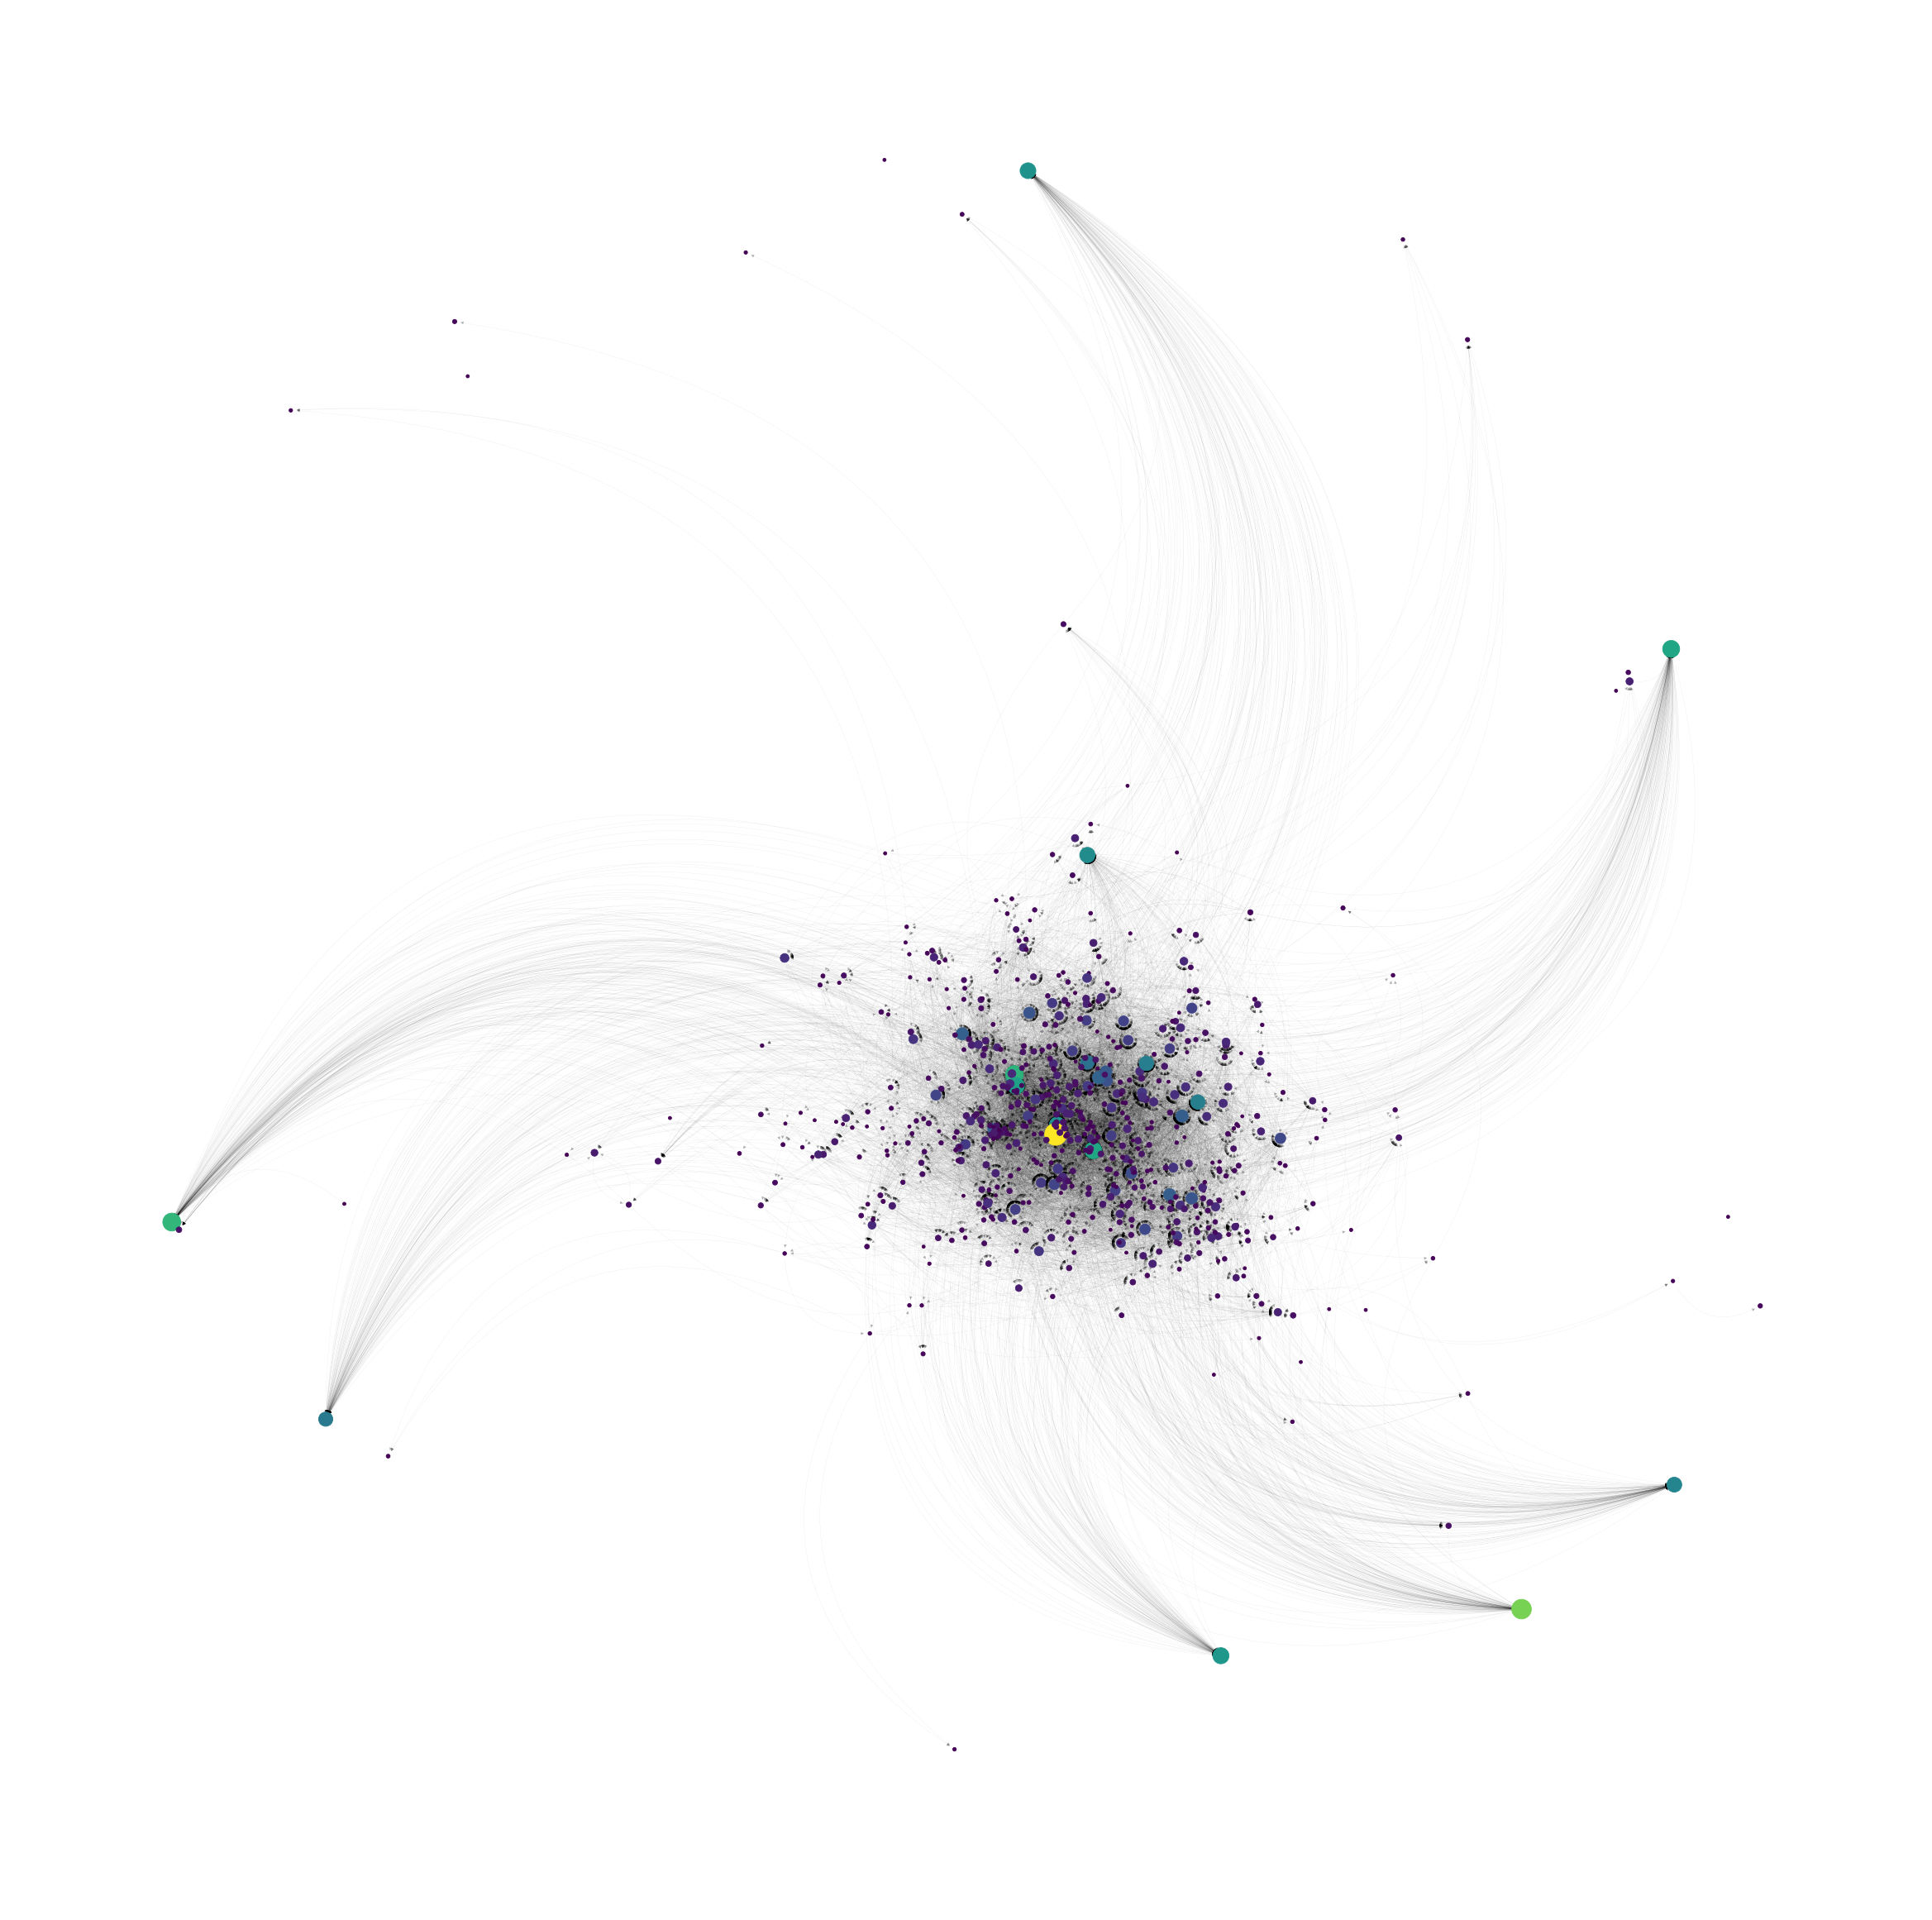

In [ ]:
plt.figure(1, figsize=(50, 50), dpi=60)
pagerank_centrality_G = nx. pagerank(G, alpha=0.8)

node_size = [
    v * 50000 for v in pagerank_centrality_G.values()
]
node_color = [20000.0 * v for v in pagerank_centrality_G.values()]


nx.draw_networkx_nodes(G, pos, node_size=node_size,node_color=node_color, alpha=1)
nx.draw_networkx_edges(G, pos, width=0.1,connectionstyle="arc3,rad=0.5", alpha=0.3)
label_options = {"ec": "k", "fc": "white", "alpha": 0.7}

plt.axis('off');